# Char model

In [1]:
import numpy as np
from char_dataset import Dataset
from char_model import CharRNN

## Dataset

In [2]:
dataset = Dataset()
dataset.load('data/dostoevsky.txt')  # dostoevsky.txt  anna.txt
model_path = 'models/dostoevsky-001/'

## Build

In [ ]:
num_layers  = 2
num_units   = 512
grad_clip   = 5.0

model = CharRNN(
    num_classes = len(dataset.vocab))

model.build(
    num_units  = num_units, 
    num_layers = num_layers, 
    grad_clip  = grad_clip)

## Train

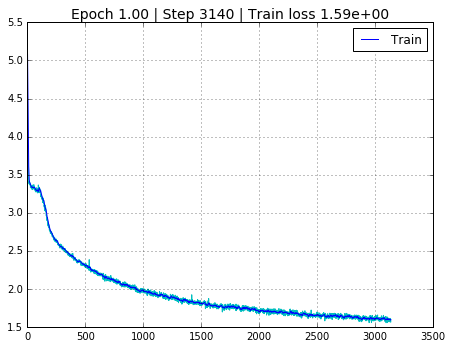

CPU times: user 15min 49s, sys: 1min 58s, total: 17min 47s
Wall time: 9min 3s


In [8]:
%%time
model.train(
    epochs        = 50, 
    batch_size    = 128, 
    seq_length    = 100,
    learning_rate = 1e-3, 
    keep_prob     = .5,
    dataset       = dataset)
model.save(model_path)

## Test

In [7]:
primes = ['Все смешалось в доме']
for prime in primes:
    print('-'*50)
    samp = model.sample(dataset, n_samples=300, top_n=3, prime=prime)
    samp = samp.replace('\n', '\n\n')
    print(samp)

--------------------------------------------------
Все смешалось в доме стоять в приновери, какой жизни на меня в совестенный последний стороны с себе стараятся все передержать, но не восторго и всегда со мной, не возможено быть не воздально сторона и стал никогда не в свою доруги. Он совершил обратования, и в таким совсем случае, что я на нее посторила на свою собствен


## Restore

In [6]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/dostoevsky-001/
